In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (293650472.py, line 2)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


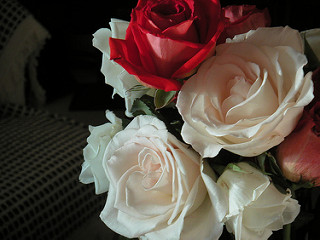

In [21]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
PIL.Image.open(str(roses[1]))

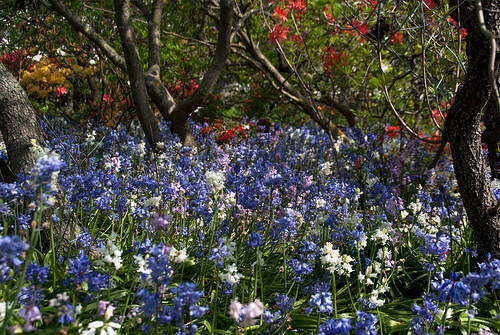

In [22]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))
PIL.Image.open(str(tulips[1]))

In [14]:
batch_size = 32
img_heigth = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size = (img_heigth, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='validation',
    seed=123,
    image_size = (img_heigth, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


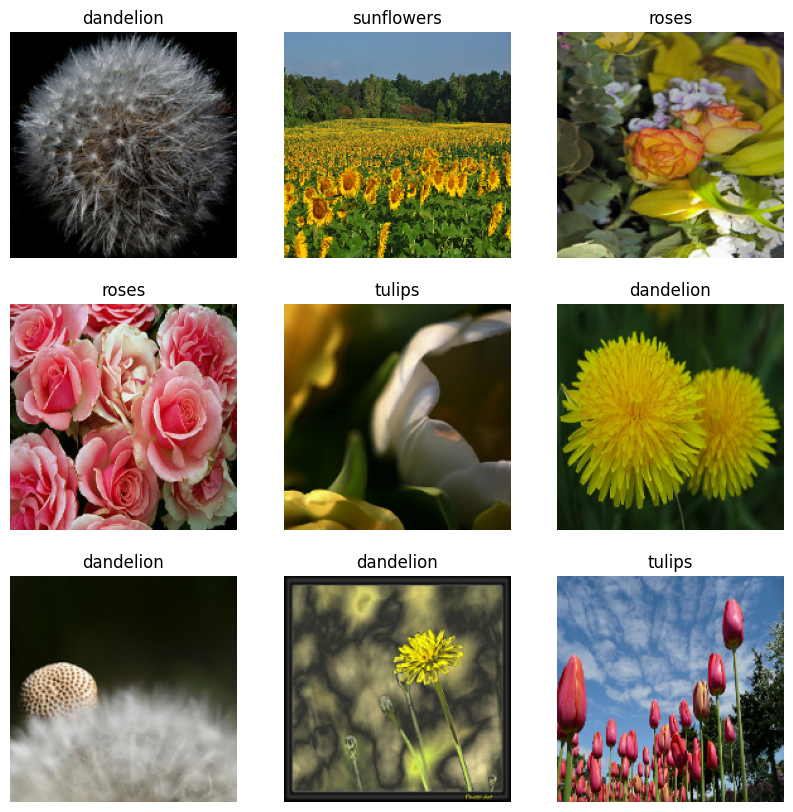

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [31]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# RGB values must be in the [0, 1] range. This is because the model has been trained with values in that range. 0-255 is too big
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [35]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_heigth, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [36]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 33s 353ms/step - loss: 1.3097 - accuracy: 0.4486 - val_loss: 1.0501 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 30s 324ms/step - loss: 0.9491 - accuracy: 0.6349 - val_loss: 0.9448 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 30s 325ms/step - loss: 0.7620 - accuracy: 0.7139 - val_loss: 0.8841 - val_accuracy: 0.6580
Epoch 4/10
92/92 [==============================] - 30s 326ms/step - loss: 0.5464 - accuracy: 0.7997 - val_loss: 1.0930 - val_accuracy: 0.6158
Epoch 5/10
92/92 [==============================] - 30s 324ms/step - loss: 0.3282 - accuracy: 0.8883 - val_loss: 1.1250 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 30s 327ms/step - loss: 0.1949 - accuracy: 0.9404 - val_loss: 1.3982 - val_accuracy: 0.6158
Epoch 7/10
92/92 [==============================] - 29s 315ms/step - loss: 0.1323 - accuracy: 0.9646 - val_loss: 1.6232 - val_accuracy: 0.6308

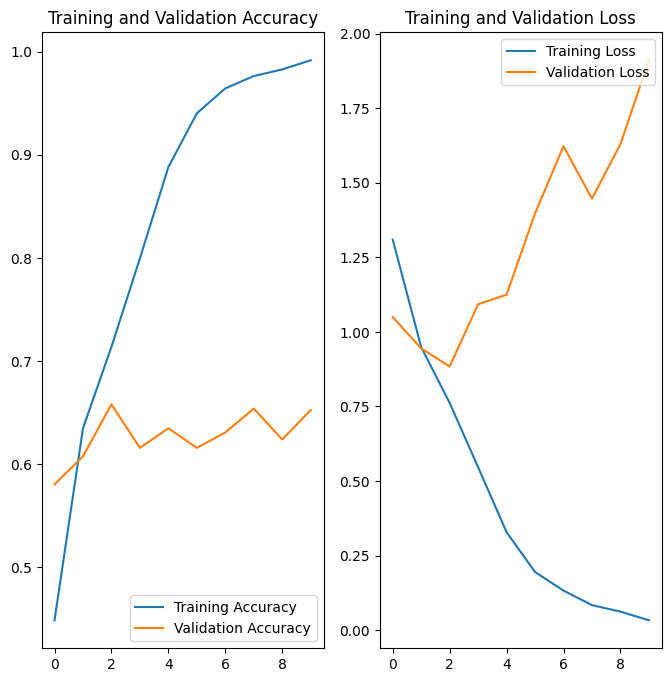

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

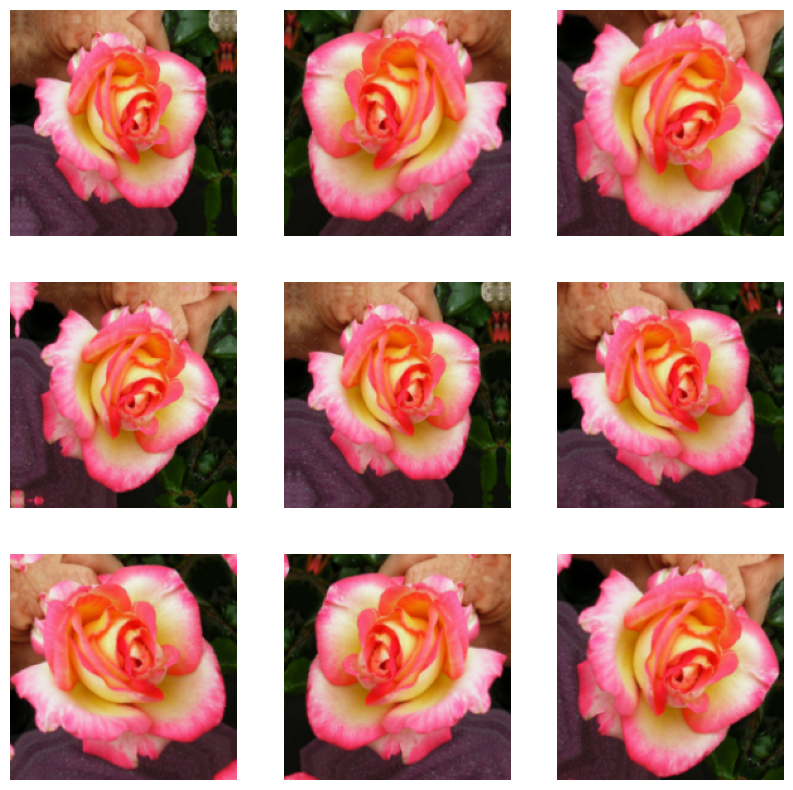

In [40]:
#low accuracy is caused by overfitting which occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.
#overfitting can be reduced by using data augmentation and dropout

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape=(img_heigth,
                                   img_width,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3 , 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [41]:
#Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
#It does this by randomly ignoring some neurons during training. This forces the network to learn features in a distributed way.
#Dropout is implemented by only keeping a neuron active with some probability p (a hyperparameter), or setting it to zero otherwise.

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [42]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [80]:
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
92/92 [==============================] - 36s 395ms/step - loss: 0.5404 - accuracy: 0.8011 - val_loss: 0.7903 - val_accuracy: 0.7003
Epoch 2/20
92/92 [==============================] - 35s 380ms/step - loss: 0.5598 - accuracy: 0.7902 - val_loss: 0.7599 - val_accuracy: 0.7275
Epoch 3/20
92/92 [==============================] - 35s 386ms/step - loss: 0.5212 - accuracy: 0.7994 - val_loss: 0.7532 - val_accuracy: 0.7139
Epoch 4/20
92/92 [==============================] - 35s 382ms/step - loss: 0.4826 - accuracy: 0.8212 - val_loss: 0.7713 - val_accuracy: 0.7071
Epoch 5/20
92/92 [==============================] - 35s 383ms/step - loss: 0.4847 - accuracy: 0.8246 - val_loss: 0.7151 - val_accuracy: 0.7302
Epoch 6/20
92/92 [==============================] - 35s 384ms/step - loss: 0.4601 - accuracy: 0.8311 - val_loss: 0.7133 - val_accuracy: 0.7330
Epoch 7/20
92/92 [==============================] - 35s 384ms/step - loss: 0.4286 - accuracy: 0.8399 - val_loss: 0.7774 - val_accuracy: 0.7302

In [2]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

NameError: name 'history' is not defined

In [86]:
#Predict New Data
#use model to identify image not included in training or validation sets

flower_url = "https://cdn.shopify.com/s/files/1/0100/6341/3329/files/ba3e99d549032d74f463a4ad382be386.jpg?v=1684315647.jpg"
flower_path = tf.keras.utils.get_file('Flowers_6', origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_heigth, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to roses with a 51.76 percent confidence.
